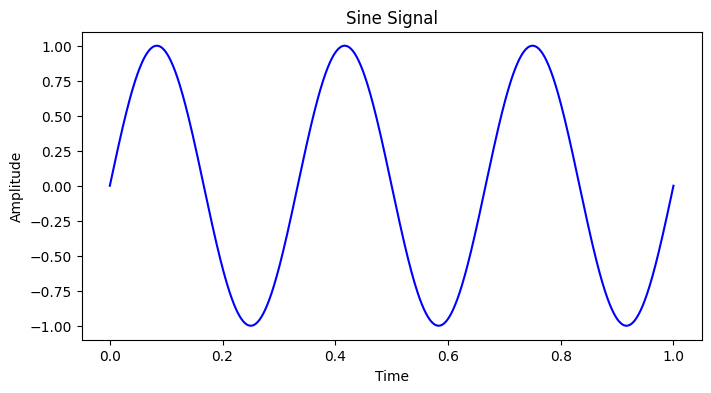

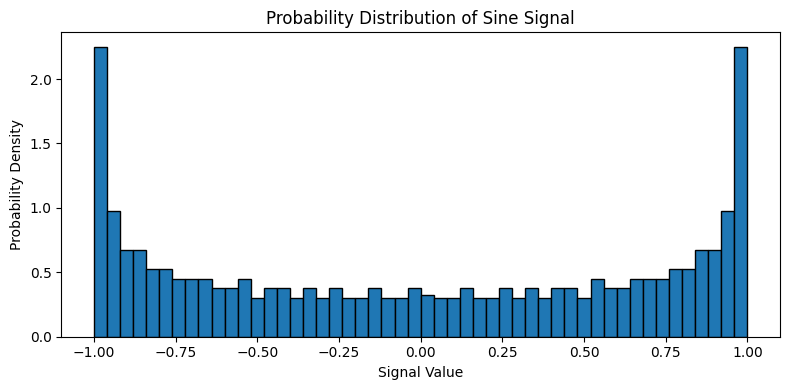

Sine Signal Entropy: 5.3726 bits


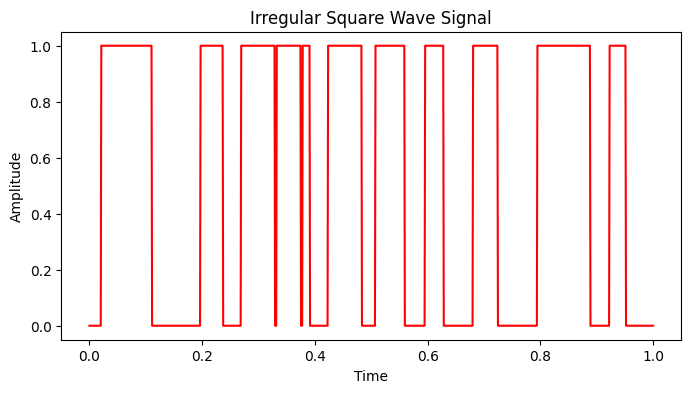

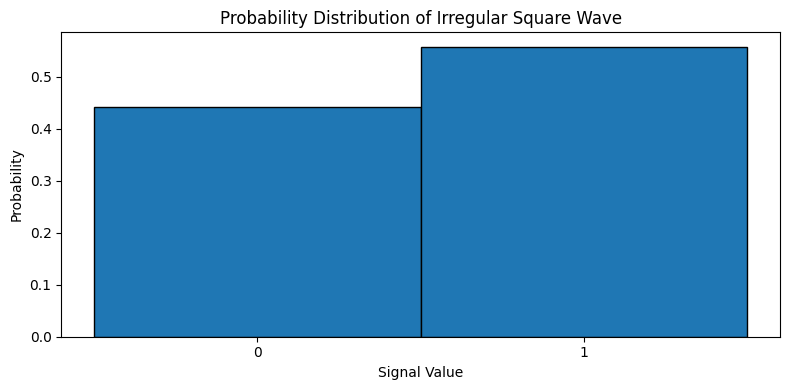

Irregular Square Wave Entropy: 0.9903 bits


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to compute entropy (in bits) from a signal
def compute_entropy(signal, bins=50):
    hist, edges = np.histogram(signal, bins=bins, density=False)
    p = hist / np.sum(hist)  # probability for each bin
    p = p[p > 0]              # remove zero entries
    return -np.sum(p * np.log2(p))

# 1. Generate a sine signal of length 1000
n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)  # one full cycle

# Plot the sine signal
plt.figure(figsize=(8, 4))
plt.plot(t, sine_signal, label='Sine Signal', color='blue')
plt.title('Sine Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')


# 2. Plot its probability distribution
plt.figure(figsize=(8, 4))
plt.hist(sine_signal, bins=50, density=True, edgecolor='black')
plt.title('Probability Distribution of Sine Signal')
plt.xlabel('Signal Value')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.show()

# 3. Calculate the information entropy
entropy_sine = compute_entropy(sine_signal, bins=50)
print(f"Sine Signal Entropy: {entropy_sine:.4f} bits")

# 4. Irregular square wave signal
#    Random durations between 1 and 100 samples for high/low phases
signal_sq = []
state = 0  # start at low (0)
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
    state = 1 - state  # toggle state
signal_sq = np.array(signal_sq[:n])

# Plot the irregular square wave signal
plt.figure(figsize=(8, 4))
plt.plot(t, signal_sq, label='Irregular Square Wave', color='red')
plt.title('Irregular Square Wave Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot its probability distribution
plt.figure(figsize=(8, 4))
plt.hist(signal_sq, bins=[-0.5, 0.5, 1.5], density=True, edgecolor='black')
plt.xticks([0, 1])
plt.title('Probability Distribution of Irregular Square Wave')
plt.xlabel('Signal Value')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()

# Calculate the information entropy
entropy_sq = compute_entropy(signal_sq, bins=2)
print(f"Irregular Square Wave Entropy: {entropy_sq:.4f} bits")


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def transfer_entropy_with_significance(x, y, nbins_x=8, nbins_y=2, k=1, n_surr=100, random_state=None):
    """
    Compute transfer entropy TE_{X->Y} and assess its significance, 
    then plot the null distribution of surrogate TE values with the empirical TE marked.

    Returns:
        te_emp: empirical TE (bits)
        p_value: fraction of surrogate TE >= te_emp
        te_surr: array of surrogate TE values
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    if len(y) != n:
        raise ValueError("Source and target must have same length")
    
    # Discretize x
    if not np.issubdtype(x.dtype, np.integer):
        xbins = np.histogram_bin_edges(x, bins=nbins_x)
        x_disc = np.digitize(x, xbins) - 1
        x_disc = np.clip(x_disc, 0, nbins_x-1)
        Nx = nbins_x
    else:
        x_disc = x
        Nx = int(x.max() - x.min() + 1)
    # Discretize y
    if not np.issubdtype(y.dtype, np.integer):
        ybins = np.histogram_bin_edges(y, bins=nbins_y)
        y_disc = np.digitize(y, ybins) - 1
        y_disc = np.clip(y_disc, 0, nbins_y-1)
        Ny = nbins_y
    else:
        y_disc = y
        Ny = int(y.max() - y.min() + 1)

    # TE computation helper
    def compute_te(xd, yd):
        counts = np.zeros((Ny, Ny, Nx), dtype=int)
        for i in range(n - k):
            counts[yd[i+k], yd[i], xd[i]] += 1
        total = counts.sum()
        N_yx = counts.sum(axis=0)
        counts_yy = counts.sum(axis=2)
        N_ycur = counts_yy.sum(axis=0)
        te_val = 0.0
        for y_next in range(Ny):
            for y_cur in range(Ny):
                for x_cur in range(Nx):
                    c = counts[y_next, y_cur, x_cur]
                    if c > 0:
                        p_xyz = c / total
                        p_y1_yx = c / N_yx[y_cur, x_cur]
                        p_y1_y = counts_yy[y_next, y_cur] / N_ycur[y_cur]
                        te_val += p_xyz * np.log2(p_y1_yx / p_y1_y)
        return te_val

    # Empirical TE
    te_emp = compute_te(x_disc, y_disc)

    # Surrogate tests
    rng = np.random.RandomState(random_state)
    te_surr = np.zeros(n_surr)
    for i in range(n_surr):
        xs = rng.permutation(x_disc)
        te_surr[i] = compute_te(xs, y_disc)

    # p-value
    p_value = np.mean(te_surr >= te_emp)

    # Plot null distribution
    plt.figure(figsize=(8, 4))
    plt.hist(te_surr, bins=25, alpha=0.7)
    plt.axvline(te_emp, linestyle='--', linewidth=2, label='Empirical TE')
    plt.xlabel('Transfer Entropy (bits)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Surrogate Null Distribution of TE')
    plt.tight_layout()
    plt.show()

    return te_emp, p_value, te_surr




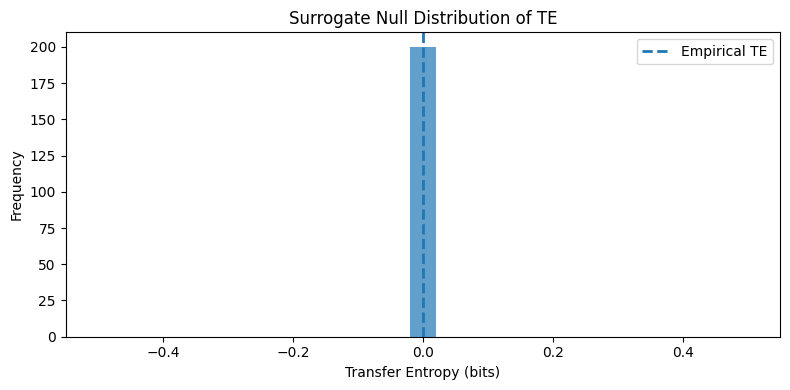

Empirical TE = 0.0000 bits, p-value = 1.000


In [8]:

n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)
# Irregular square wave
signal_sq = []
state = 0
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
signal_sq = np.array(signal_sq[:n])

te_val, p_val, surr = transfer_entropy_with_significance(
    sine_signal, signal_sq, nbins_x=8, nbins_y=2, k=1, n_surr=200, random_state=42
)
print(f"Empirical TE = {te_val:.4f} bits, p-value = {p_val:.3f}")

In [4]:
import numpy as np

# 1. Regenerate the synthetic data
n = 1000
t = np.linspace(0, 1, n)
sine_signal = np.sin(6 * np.pi * t)

# Irregular square wave (0/1)
signal_sq = []
state = 0
while len(signal_sq) < n:
    dur = np.random.randint(1, 101)
    signal_sq.extend([state] * dur)
signal_sq = np.array(signal_sq[:n])

# 2. Discretize the source (sine) into 8 equiprobable bins
nbins_x = 8
xbins = np.histogram_bin_edges(sine_signal, bins=nbins_x)
x_disc = np.digitize(sine_signal, xbins) - 1  # initial bin indices may go 0..8
# Clip any index equal to nbins_x back to nbins_x-1
x_disc = np.where(x_disc == nbins_x, nbins_x - 1, x_disc)

# Discretize the target (square) into its natural 2 states
y_disc = signal_sq  # already 0 or 1

# 3. Compute joint counts: count[y_next, y_cur, x_cur]
Ny = 2   # target alphabet size
Nx = nbins_x
counts = np.zeros((Ny, Ny, Nx), dtype=int)
for i in range(n - 1):
    x_cur = x_disc[i]
    y_cur = y_disc[i]
    y_next = y_disc[i + 1]
    counts[y_next, y_cur, x_cur] += 1

# 4. Marginal counts
# N(y_cur, x_cur) = sum over y_next
N_yx = counts.sum(axis=0)          # shape (y_cur, x_cur)
# N(y_next, y_cur) = sum over x_cur
counts_yy = counts.sum(axis=2)     # shape (y_next, y_cur)
# N(y_cur) = sum over y_next of counts_yy
N_ycur = counts_yy.sum(axis=0)     # shape (y_cur,)

# 5. Total transitions (n - 1)
total = counts.sum()

# 6. Compute transfer entropy TE_{X→Y}
TE_xy = 0.0
for y_next in range(Ny):
    for y_cur in range(Ny):
        for x_cur in range(Nx):
            c_xyz = counts[y_next, y_cur, x_cur]
            if c_xyz > 0:
                # joint probability p(y_next, y_cur, x_cur)
                p_xyz = c_xyz / total
                # conditional probabilities
                p_y1_given_yx = c_xyz / N_yx[y_cur, x_cur]
                p_y1_given_y  = counts_yy[y_next, y_cur] / N_ycur[y_cur]
                # accumulate TE
                TE_xy += p_xyz * np.log2(p_y1_given_yx / p_y1_given_y)

print(f"Transfer Entropy (sine → square) = {TE_xy:.6f} bits")


Transfer Entropy (sine → square) = 0.000000 bits


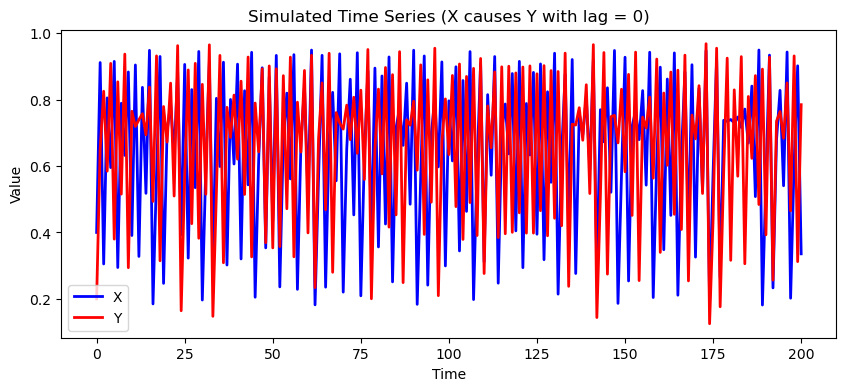

TE(pre→residual) = 0.5104 bits


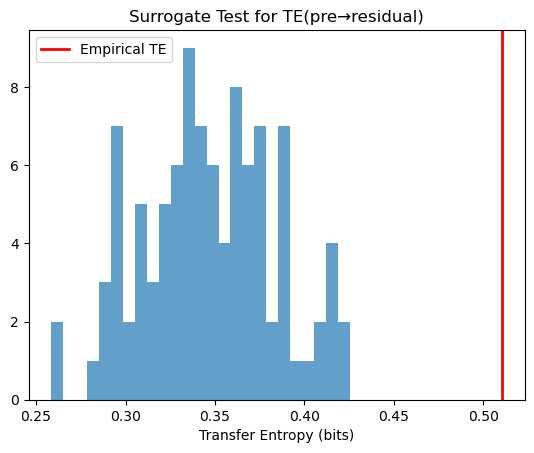

p-value = 0.000


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}



r_x = 3.8        
r_y = 3.5       
B_yx = 0.1      
LAG = 0          
t_total = 200    

X = np.zeros(t_total + 1)
Y = np.zeros(t_total + 1)
X[0] = 0.4
Y[0] = 0.2

for t in range(t_total):
    X[t+1] = r_x * X[t] * (1 - X[t])
    if (t + 1) < LAG:
        Y[t+1] = r_y * Y[t] * (1 - Y[t])
    else:
        Y[t+1] = r_y * Y[t] * (1 - Y[t]) + B_yx * X[t - LAG + 1]

time = np.arange(t_total + 1)
plt.figure(figsize=(10, 4))
plt.plot(time, X, 'b-', linewidth=2, label='X')
plt.plot(time, Y, 'r-', linewidth=2, label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Simulated Time Series (X causes Y with lag = {LAG})')
plt.legend()
plt.show()


# save X and Y to csv and add a time column
df = pd.DataFrame({
    "Time": time,
    "X": X,
    "Y": Y,
})
# df.to_csv('X_Y.csv', index=False)






# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df['X'].values      # source (precession)
y = df['Y'].values    # target (residual)

# y = df['X'].values      # source (precession)
# x = df['Y'].values    # target (residual)

# # flip x and y upside down
# x = x[::-1]
# y = y[::-1]

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")